# New York Neighborhood Analysis

## 1. Importing dependencies

In [1]:
# importing necessary dependencies
import pandas as pd, numpy as np
import requests # to handle html requests to Foursquare API
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # for obtaining geo-spatial coordinates
import json
from pandas.io.json import json_normalize # for json to data-frame data conversion

import seaborn as sns
import folium # map-plotting library
import matplotlib.pyplot as plt # plotting library
%matplotlib inline 
import matplotlib.cm as cm # plotting dependencies
import matplotlib.colors as colors # plotting dependencies

from sklearn.cluster import KMeans # kMeans machine learning library

#!conda install -c conda-forge wordcloud --yes
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.10

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.10

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



## 2. Data collection and cleaning

In [2]:
# downloading the new york city neighborhood data
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)


The dataset contains geo-spatial information about 306 neighborhoods scattered across 5 Boroughs in dictionary format. We are primarily interested in the neighborhood name, borough it is in and the spatial coordinates of the neighborhood. 

Below is one example of the data point of the neighborhood from the dataset.

In [3]:
newyork_data['features'][0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### 2.1 Tranform the data into a pandas dataframe
Now, we'll transform the neighborhood data to a data frame by looping through the dictionary elements and extracting the borough name, neighborrhodd name and lat-long coordinates

In [4]:
neighborhoods = pd.DataFrame(columns=['Borough', 'Neighborhood', 'Latitude', 'Longitude'])

for data in newyork_data['features']:
    borough = data['properties']['borough'] 
    name = data['properties']['name']
    
    # note that the coordinates are in [longitude,latitude] format
    latlon = data['geometry']['coordinates']
    lat,lon = latlon[1],latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': name,
                                          'Latitude': lat,
                                          'Longitude': lon}, ignore_index=True)

print(neighborhoods.shape)    
neighborhoods.head(6)

(306, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818


#### 2.2 Visualize the neighborhood map
Here, we'll use geopy's geocoder to get latitude and longitude of the New york city for Folium map on which we'll superimpose the neighborhood data. In order to define an instance of the geocoder, we'll define a user_agent and name it ny_exp

In [5]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_exp")
location = geolocator.geocode(address)
lat = location.latitude
long = location.longitude
print(f'The geograpical coordinate of New York City are {lat}, {long}.')

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [6]:
# creating a folium map
map_ny = folium.Map(location=[lat, long], tiles = "Stamen Terrain", zoom_start=10)

# adding markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='purple',
        parse_html=False).add_to(map_ny) 
map_ny

#### 2.3 Collecting 100 venues around each neighborhood within 500 meters distance

In [7]:
# Foursquare API credentials
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### 2.4 Collect each venue's attributes

Here, we are using each venue's unique id to fetch attributes like the costliness of the venue, number of likes it received, and average rating it received from the users who visited it.

#### 2.5 Combining the venue data and its attribute data frames

## 3. Data Exploration


In [8]:
data = pd.read_csv('venue_data.csv')

In [9]:
data.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Shortname,Price,Venue Likes,Venue Rating
0,Bronx,Wakefield,40.894705,-73.847201,4c537892fd2ea593cb077a28,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,Desserts,1.0,18.0,8.5
1,Bronx,Wakefield,40.894705,-73.847201,4d6af9426107f04dedeb297a,Rite Aid,40.896649,-73.844846,Pharmacy,Pharmacy,-99.0,12.0,7.2
2,Bronx,Wakefield,40.894705,-73.847201,4c783cef3badb1f7e4244b54,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,Ice Cream,1.0,14.0,7.2
3,Bronx,Wakefield,40.894705,-73.847201,508af256e4b0578944c87392,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant,Caribbean,2.0,7.0,6.9
4,Bronx,Wakefield,40.894705,-73.847201,4c25c212f1272d7f836385c5,Dunkin',40.890459,-73.849089,Donut Shop,Donuts,1.0,10.0,6.8


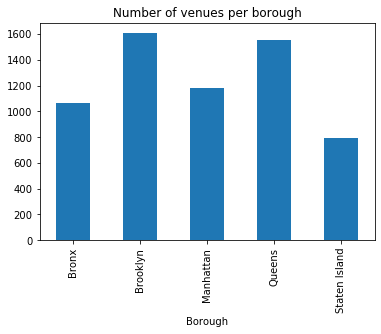

In [10]:
data.groupby('Borough').count()['Venue Category'].plot.bar(title='Number of venues per borough')

In [11]:
# generating data-frame containing top 10 nd bottom 10 venues in each borough
grp_df = data.groupby(['Borough','Venue Category']).size().reset_index(name='count')

# data frame from grp_df having top 10 and bottom 10 occuring venues per borough
bronx_top = grp_df[grp_df['Borough']==grp_df['Borough'].unique()[0]].sort_values(by=['count'],ascending=False).head(10)
bronx_bottom = grp_df[grp_df['Borough']==grp_df['Borough'].unique()[0]].sort_values(by=['count']).head(10)
brooklyn_top = grp_df[grp_df['Borough']==grp_df['Borough'].unique()[1]].sort_values(by=['count'],ascending=False).head(10)
brooklyn_bottom = grp_df[grp_df['Borough']==grp_df['Borough'].unique()[1]].sort_values(by=['count']).head(10)
manhattan_top = grp_df[grp_df['Borough']==grp_df['Borough'].unique()[2]].sort_values(by=['count'],ascending=False).head(10)
manhattan_bottom = grp_df[grp_df['Borough']==grp_df['Borough'].unique()[2]].sort_values(by=['count']).head(10)
queens_top = grp_df[grp_df['Borough']==grp_df['Borough'].unique()[3]].sort_values(by=['count'],ascending=False).head(10)
queens_bottom = grp_df[grp_df['Borough']==grp_df['Borough'].unique()[3]].sort_values(by=['count']).head(10)
statenisland_top = grp_df[grp_df['Borough']==grp_df['Borough'].unique()[4]].sort_values(by=['count'],ascending=False).head(10)
statenisland_bottom = grp_df[grp_df['Borough']==grp_df['Borough'].unique()[4]].sort_values(by=['count']).head(10)

grp_df_top = pd.concat([bronx_top,brooklyn_top,manhattan_top,queens_top,statenisland_top,],ignore_index=True)
grp_df_bot = pd.concat([bronx_bottom,brooklyn_bottom,manhattan_bottom,queens_bottom,statenisland_bottom],ignore_index=True)

#### 3.1 Visualize Top 10 locations in each Borough

Borough: Bronx


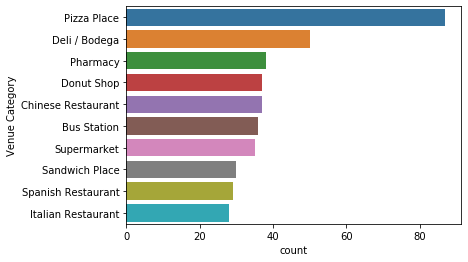

In [12]:
print("Borough: Bronx")
sns.barplot(x='count',y='Venue Category',data=bronx_top,orient='h',saturation=.7);

Borough: Brooklyn


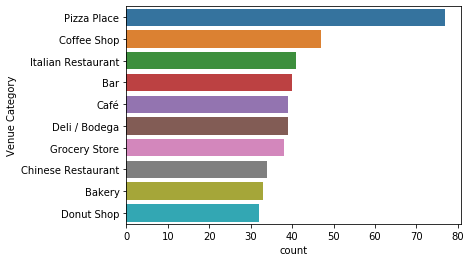

In [13]:
print("Borough: Brooklyn")
sns.barplot(x='count',y='Venue Category',data=brooklyn_top,orient='h',saturation=.7);

Borough: Manhattan


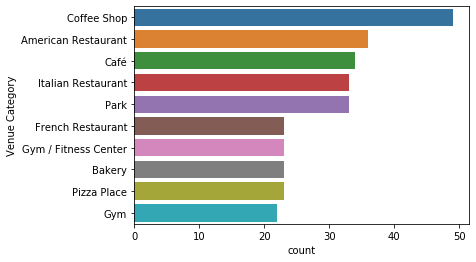

In [14]:
print("Borough: Manhattan")
sns.barplot(x='count',y='Venue Category',data=manhattan_top,orient='h',saturation=.7);

Borough: Queens


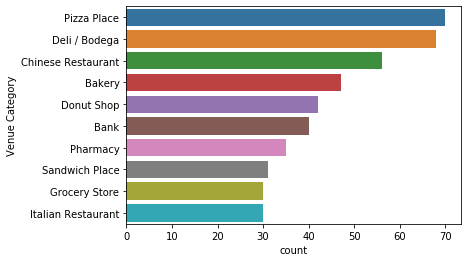

In [15]:
print("Borough: Queens")
sns.barplot(x='count',y='Venue Category',data=queens_top,orient='h',saturation=.7);

Borough: Staten Island


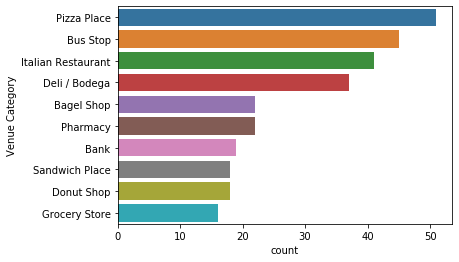

In [16]:
print("Borough: Staten Island")
sns.barplot(x='count',y='Venue Category',data=statenisland_top,orient='h',saturation=.7);

#### 3.2 Visualize Top 20 locations in all of New york City by borough

In [17]:
top20_venues = grp_df.groupby('Venue Category').sum().sort_values(by='count',ascending=False)[:20].index
top_20_df = grp_df[[True if cat in top20_venues else False for cat in grp_df['Venue Category'].values]]
top_20_df = top_20_df.sort_values(by='count',ascending=False)

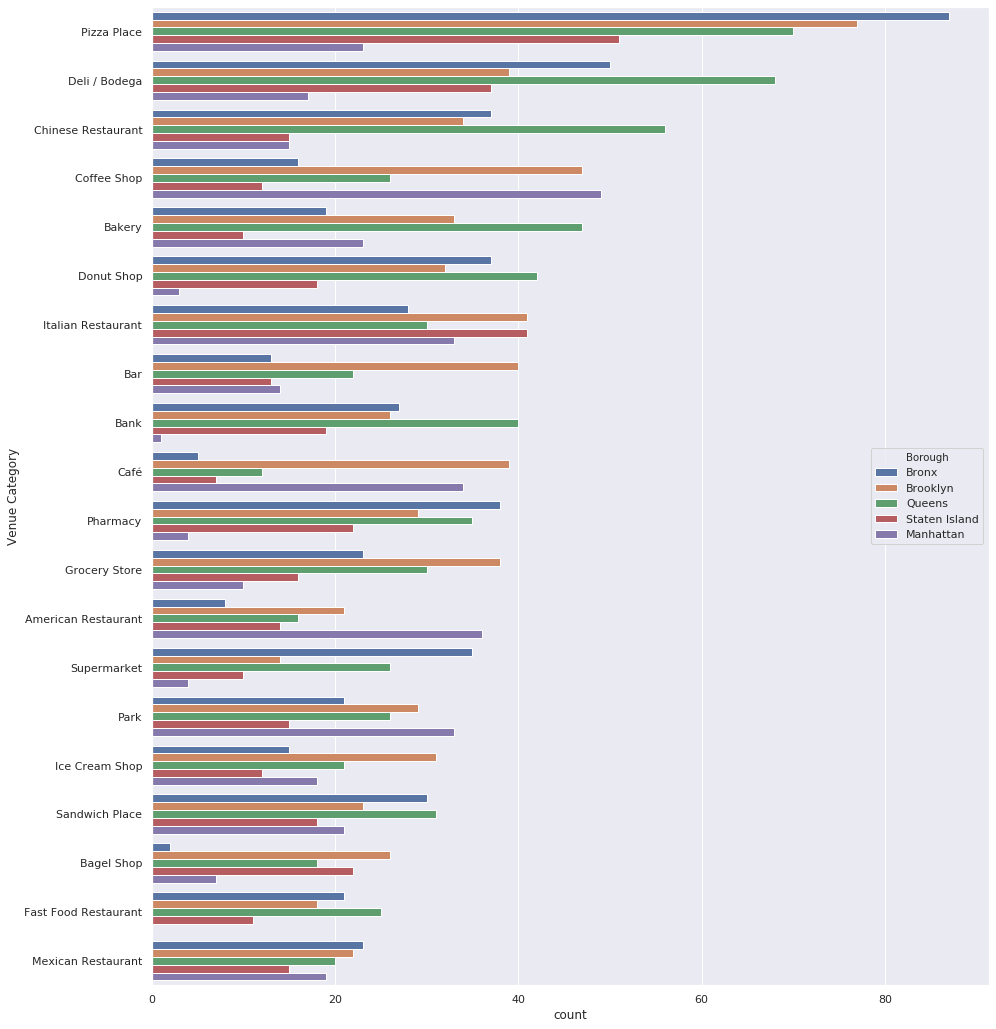

In [18]:
sns.set(rc={'figure.figsize':(15,18)})
sns.barplot(x='count',y='Venue Category',hue='Borough',orient='h',data=top_20_df);

#### 3.3 Analyzing each neighborhood

In [19]:
data.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Shortname,Price,Venue Likes,Venue Rating
0,Bronx,Wakefield,40.894705,-73.847201,4c537892fd2ea593cb077a28,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,Desserts,1.0,18.0,8.5
1,Bronx,Wakefield,40.894705,-73.847201,4d6af9426107f04dedeb297a,Rite Aid,40.896649,-73.844846,Pharmacy,Pharmacy,-99.0,12.0,7.2
2,Bronx,Wakefield,40.894705,-73.847201,4c783cef3badb1f7e4244b54,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,Ice Cream,1.0,14.0,7.2
3,Bronx,Wakefield,40.894705,-73.847201,508af256e4b0578944c87392,Cooler Runnings Jamaican Restaurant Inc,40.898276,-73.850381,Caribbean Restaurant,Caribbean,2.0,7.0,6.9
4,Bronx,Wakefield,40.894705,-73.847201,4c25c212f1272d7f836385c5,Dunkin',40.890459,-73.849089,Donut Shop,Donuts,1.0,10.0,6.8


In [20]:
# one hot encoding
data1hot = pd.get_dummies(data[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
data1hot['Neighborhood_name'] = data['Neighborhood'].values 

# move neighborhood column to the first column
fixed_columns = [data1hot.columns[-1]] + list(data1hot.columns[:-1])
data1hot = data1hot[fixed_columns]

dataGrouped = data1hot.groupby('Neighborhood_name').mean().reset_index()
dataGrouped.head() 

,Neighborhood_name,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Allerton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arrochar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
def return_most_common_venues(row, n):
    row_cats = row.iloc[1:]
    row_cats = row_cats.sort_values(ascending=False)
    return row_cats.index.values[0:n]

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(10):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hoodVenue = pd.DataFrame(columns=columns)
hoodVenue['Neighborhood'] = dataGrouped['Neighborhood_name']

for ind in np.arange(dataGrouped.shape[0]):
    hoodVenue.iloc[ind, 1:] = return_most_common_venues(dataGrouped.iloc[ind, :],10)

hoodVenue.head(10)

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Spa,Supermarket,Chinese Restaurant,Pharmacy,Fried Chicken Joint,Breakfast Spot,Gas Station,Fast Food Restaurant
1,Annadale,Park,Pizza Place,Dance Studio,Cosmetics Shop,Sports Bar,Restaurant,Diner,Train Station,Event Service,Event Space
2,Arden Heights,Deli / Bodega,Pharmacy,Coffee Shop,Bus Stop,Pizza Place,Filipino Restaurant,Eye Doctor,Factory,Falafel Restaurant,Farm
3,Arlington,Intersection,Liquor Store,American Restaurant,Bus Stop,Grocery Store,Filipino Restaurant,Eye Doctor,Factory,Falafel Restaurant,Farm
4,Arrochar,Bus Stop,Deli / Bodega,Pizza Place,Italian Restaurant,Hotel,Bagel Shop,Sandwich Place,Athletics & Sports,Pharmacy,Outdoors & Recreation
5,Arverne,Surf Spot,Metro Station,Sandwich Place,Donut Shop,Playground,Thai Restaurant,Bed & Breakfast,Coffee Shop,Board Shop,Pizza Place
6,Astoria,Greek Restaurant,Seafood Restaurant,Gourmet Shop,Gym,Dessert Shop,Brazilian Restaurant,Grocery Store,Martial Arts Dojo,Thai Restaurant,Middle Eastern Restaurant
7,Astoria Heights,Italian Restaurant,Pizza Place,Bus Station,Bakery,Gourmet Shop,Hostel,Playground,Plaza,Bowling Alley,Supermarket
8,Auburndale,Deli / Bodega,Hookah Bar,Pet Store,Pharmacy,Fast Food Restaurant,Toy / Game Store,Train,Miscellaneous Shop,Korean Restaurant,Noodle House
9,Bath Beach,Italian Restaurant,Bubble Tea Shop,Kids Store,Chinese Restaurant,Cantonese Restaurant,Fast Food Restaurant,Sushi Restaurant,Burger Joint,Donut Shop,Coffee Shop


## 4. Applying KMeans Clustering on neighborhoods


In [22]:
kclusters = 5
clusterdf = dataGrouped.drop('Neighborhood_name', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clusterdf)
hoodVenue.insert(0, 'Cluster Labels', kmeans.labels_)

datamerged = neighborhoods.join(hoodVenue.set_index('Neighborhood'), on='Neighborhood')
datamerged.dropna(axis=0,inplace=True)
datamerged.head() 

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,1.0,Gas Station,Dessert Shop,Sandwich Place,Donut Shop,Pharmacy,Laundromat,Ice Cream Shop,Caribbean Restaurant,Food Truck,Factory
1,Bronx,Co-op City,40.874294,-73.829939,3.0,Bus Station,Baseball Field,Pizza Place,Grocery Store,Park,Mattress Store,Bar,Trail,Gift Shop,Pharmacy
2,Bronx,Eastchester,40.887556,-73.827806,3.0,Bus Station,Caribbean Restaurant,Deli / Bodega,Diner,Metro Station,Donut Shop,Bowling Alley,Fast Food Restaurant,Chinese Restaurant,Bakery
3,Bronx,Fieldston,40.895437,-73.905643,1.0,Playground,River,Bus Station,Plaza,Yoga Studio,Event Space,Eye Doctor,Factory,Falafel Restaurant,Farm
4,Bronx,Riverdale,40.890834,-73.912585,1.0,Park,Playground,Food Truck,Bank,Bus Station,Gym,Plaza,Home Service,Field,Eye Doctor


In [ ]:
# create map
map_clusters = folium.Map(location=[lat, long], tiles = "Stamen Toner",zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
colors_array = ['cyan','Red','green','orange','purple']
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(datamerged['Latitude'], datamerged['Longitude'], datamerged['Neighborhood'], datamerged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Cluster Statistics

#### Cluster 1

Cluster one contains 18 neighborhoods,which are spread out across 5 Boroughs in manner:
Staten Island    0.833333
Queens           0.111111
Brooklyn         0.055556
Name: Borough, dtype: float64

Top Locations of Cluster 1 are:


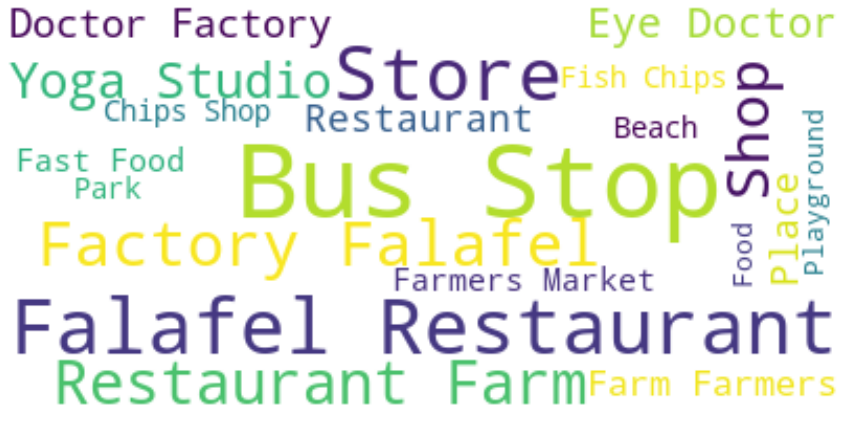

In [66]:
# generating data frame containing cluster 1 entries
cl1 = datamerged[datamerged['Cluster Labels']==0]
print('Cluster one contains {} neighborhoods,which are spread out across 5 Boroughs in manner:'.format(cl1.shape[0]))
print(pd.Index(cl1['Borough']).value_counts(normalize=True))
print()

print('Top Locations of Cluster 1 are:')
venueList = ' '.join(['-'.join(i.split()) for i in cl1.iloc[:,5:].values.flatten()])
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(venueList)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Cluster 2

Cluster one contains 148 neighborhoods,which are spread out across 5 Boroughs in manner:
Brooklyn         0.317568
Manhattan        0.270270
Queens           0.250000
Staten Island    0.087838
Bronx            0.074324
Name: Borough, dtype: float64

Top Locations of Cluster 2 are:


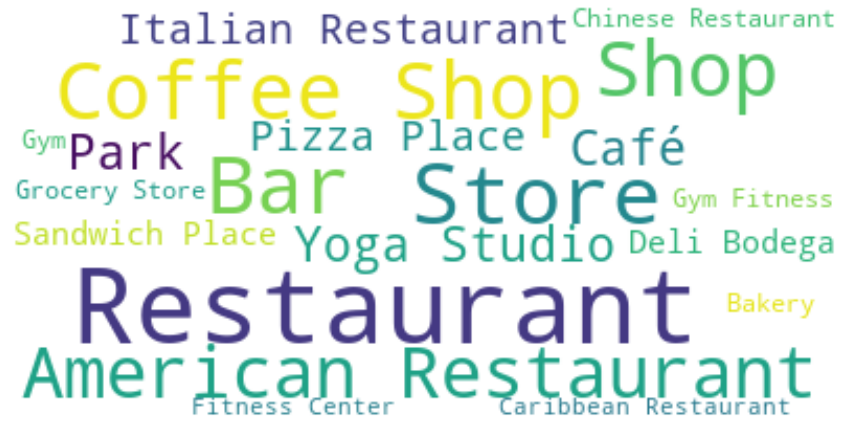

In [34]:
cl2 = datamerged[datamerged['Cluster Labels']==1]
print('Cluster one contains {} neighborhoods,which are spread out across 5 Boroughs in manner:'.format(cl2.shape[0]))
print(pd.Index(cl2['Borough']).value_counts(normalize=True))
print()
print('Top Locations of Cluster 2 are:')
venueList = ' '.join(['-'.join(i.split()) for i in cl2.iloc[:,5:].values.flatten()])
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(venueList)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Cluster 3

Cluster one contains 26 neighborhoods,which are spread out across 5 Boroughs in manner:
Staten Island    0.384615
Queens           0.307692
Bronx            0.230769
Brooklyn         0.076923
Name: Borough, dtype: float64

Top Locations of Cluster 3 are:


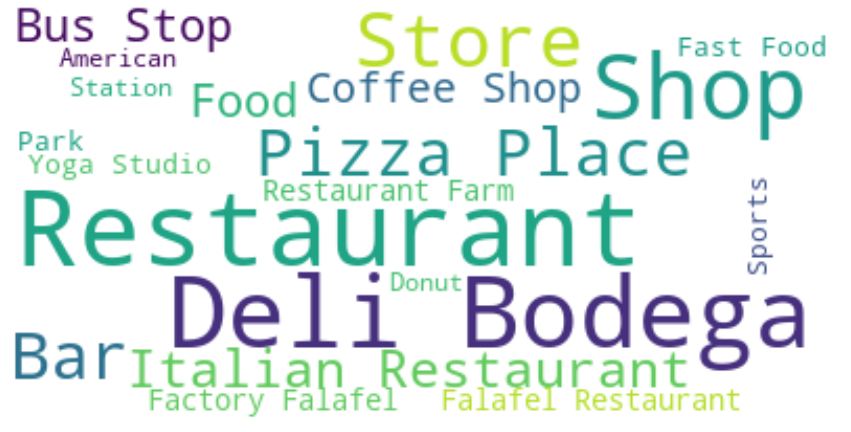

In [35]:
cl3 = datamerged[datamerged['Cluster Labels']==2]
print('Cluster one contains {} neighborhoods,which are spread out across 5 Boroughs in manner:'.format(cl3.shape[0]))
print(pd.Index(cl3['Borough']).value_counts(normalize=True))
print()
print('Top Locations of Cluster 3 are:')
venueList = ' '.join(['-'.join(i.split()) for i in cl3.iloc[:,5:].values.flatten()])
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(venueList)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### CLuster 4

Cluster one contains 110 neighborhoods,which are spread out across 5 Boroughs in manner:
Bronx            0.318182
Queens           0.300000
Staten Island    0.200000
Brooklyn         0.181818
Name: Borough, dtype: float64

Top Locations of Cluster 4 are:


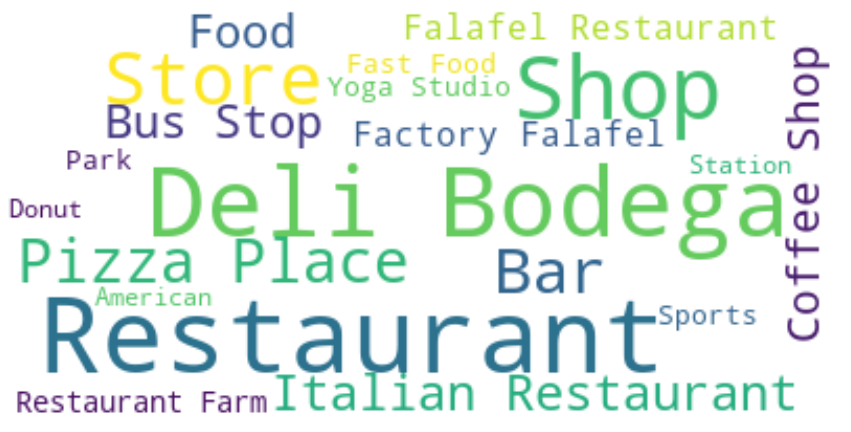

In [59]:
cl4 = datamerged[datamerged['Cluster Labels']==3]
print('Cluster one contains {} neighborhoods,which are spread out across 5 Boroughs in manner:'.format(cl4.shape[0]))
print(pd.Index(cl4['Borough']).value_counts(normalize=True))
print()
print('Top Locations of Cluster 4 are:')
v = cl3.iloc[:,4:].values.flatten()[[isinstance(i, str) for i in cl3.iloc[:,4:].values.flatten()]]
venueList = ' '.join(['-'.join(i.split()) for i in v])
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(venueList)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Cluster 5

Cluster one contains 2 neighborhoods,which are spread out across 5 Boroughs in manner:
Queens           0.5
Staten Island    0.5
Name: Borough, dtype: float64

Top Locations of Cluster 5 are:


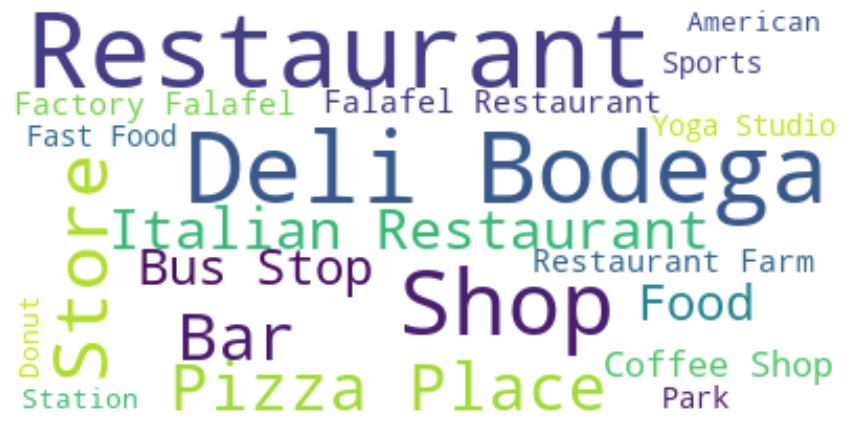

In [37]:
cl5 = datamerged[datamerged['Cluster Labels']==4]
print('Cluster one contains {} neighborhoods,which are spread out across 5 Boroughs in manner:'.format(cl5.shape[0]))
print(pd.Index(cl5['Borough']).value_counts(normalize=True))
print()
print('Top Locations of Cluster 5 are:')
venueList = ' '.join(['-'.join(i.split()) for i in cl3.iloc[:,5:].values.flatten()])
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(venueList)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()